# Importing Packages
First, we start by importing some packages like `numpy`, `matplotlib` and also `torch`.

In [ ]:
import torch
import numpy as np
from torch import nn 
from torch.nn import functional as F
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

# Chossing a device 
If there is a cuda available, we are going to train and use our model on gpu


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Encoder Implementation
Here, we define and implement the encoder part of the model, $Q(z|X)$. 

Throughout two hidden layers (linear nets using relu function), the encoder will reduce the dimenstion size of the initial feature space to a samller size.
Later, we will expect two outputs from this network, namely `mu` and `log_var`. Which are the $\mu$ and $\log(\sigma^2)$ of the latent points.




In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc_mu = nn.Linear(hidden_sizes[1], output_size)
        self.fc_var = nn.Linear(hidden_sizes[1], output_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

# Decoder Implementation
Here, we define and implement the decoder part of the model, $P(X|z)$. 

Throughout two hidden layers (linear nets using relu and sigmoid function), the deocder will increase the dimenstion size of the latent feature space to a greater size, equal to that of the main feature space.




In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    def forward(self, z):
        z = self.relu(self.fc1(z))
        z = self.relu(self.fc2(z))
        x_hat = self.sigmoid(self.fc3(z))
        return x_hat

# VAE Implementation
By connections two previous networks, decoder and encoder, we implement our vanilla VAE.

The encoder will get the dataset as inputs and create two vectors, `mu` and `log_var` of the latent point. By sampling using these two vectors in function `reparam_sample`, we feed the decoder network, so it can take the sampled point back to the original feature space.

In [ ]:
class VAE(nn.Module):
    def __init__(self, feature_size, hidden_sizes):
        super().__init__()
        self.encoder = Encoder(feature_size, hidden_sizes, 2)
        self.decoder = Decoder(2, hidden_sizes[::-1], feature_size)

    def reparam_sample(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z)
        return x_hat, x, mu, log_var, z

# Train and Analyze VAE
In this class, we train the model using two loss forms. One is the reconstruction loss which measures the variance between the input vector and output vector created by the decoder. The other one measures how close the distribution of the latent points is to Nomal distribution, namely $N(0, I)$. For this error we use ‍‍‍‍‍‍‍‍‍*kullback-leibler divergence*, which measures the divergence between two distributions. 

Later in this class, in function `show_info` and `show_samples`, we visualize three plots:


1.   Train and validation loss throughout epochs
2.   The distribution of the latent space, as they are in a 2D feature space.  
3.   100 sample digits, reconstructed  by the the trained decoder using 100 points sampled from the 2D feature space.



For epoch: 1, train loss is 11006.81448 and validation loss is 10477.79480
For epoch: 2, train loss is 9852.46507 and validation loss is 9228.95506
For epoch: 3, train loss is 9536.94165 and validation loss is 8963.90085
For epoch: 4, train loss is 9379.11805 and validation loss is 8850.17036
For epoch: 5, train loss is 9280.11531 and validation loss is 8764.92877
For epoch: 6, train loss is 9205.79590 and validation loss is 8686.58167
For epoch: 7, train loss is 9141.71486 and validation loss is 8624.67341
For epoch: 8, train loss is 9090.76060 and validation loss is 8623.20918
For epoch: 9, train loss is 9063.98489 and validation loss is 8619.37464
For epoch: 10, train loss is 9025.73695 and validation loss is 8584.34256



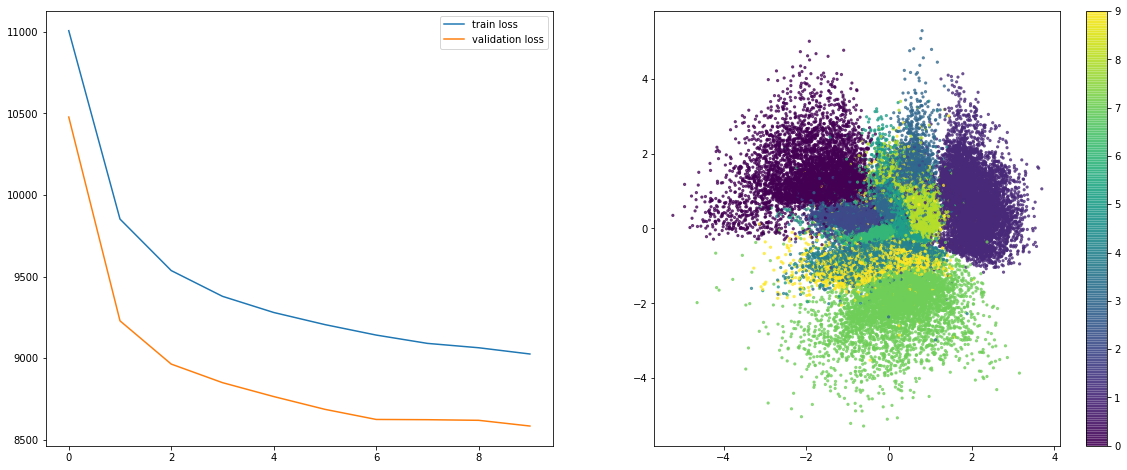

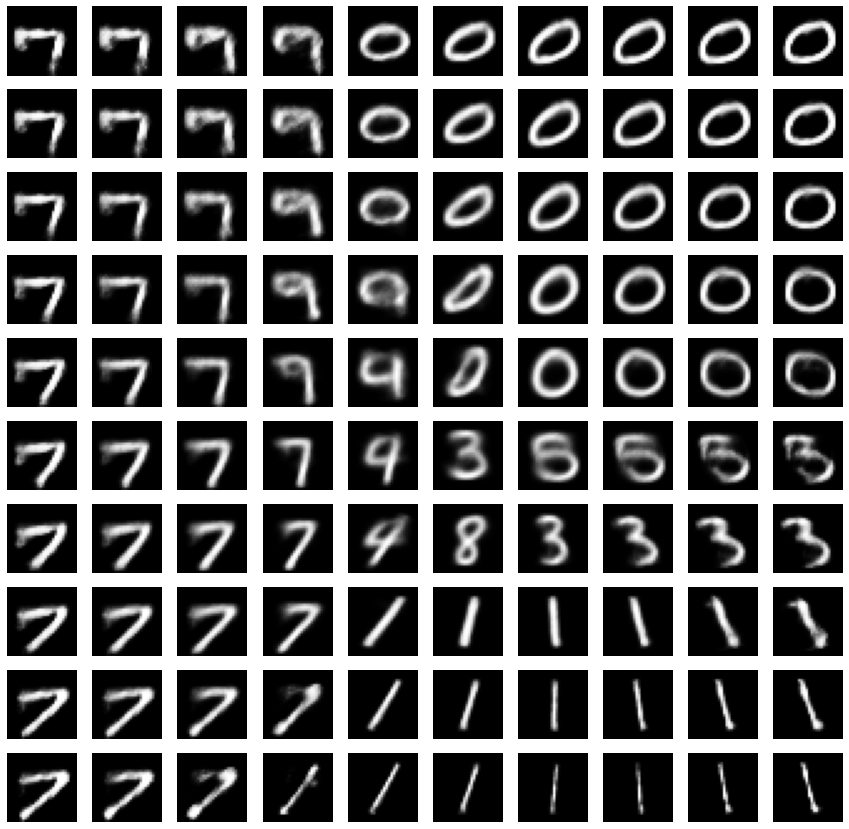

In [ ]:
class Model():
    def __init__(self, hidden_sizes):
        data = self.fetch_data()
        self.trainloader, self.validationloader = data
        self.vae = VAE(784, hidden_sizes=hidden_sizes).to(device)

    def train(self, epochs=10):
        optimizer = torch.optim.Adam(self.vae.parameters())
        self.train_losses = []
        self.valid_losses = []
        for epoch in range(epochs):
            train_running_loss = 0
            valid_running_loss = 0
            for train_images, _ in self.trainloader:
                train_images = train_images.to(device)
                train_images.resize_(len(train_images), 784)
                x_hat, x, mu, log_var, z = self.vae(train_images)
                reconstruction_loss = F.binary_cross_entropy(x_hat, train_images, reduction='sum')
                kldiv_loss = 0.5 * torch.sum(torch.exp(log_var) + mu ** 2 - 1 - log_var)
                loss = kldiv_loss + reconstruction_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_running_loss += loss.item()

                valid_images, _ = iter(self.validationloader).next()
                valid_images = valid_images.to(device).resize_(len(valid_images), 784)
                x_hat, x, mu, log_var, z = self.vae(valid_images)
                reconstruction_valid_loss = F.binary_cross_entropy(x_hat, valid_images, reduction='sum')
                kldiv_valid_loss = 0.5 * torch.sum(torch.exp(log_var) + mu ** 2 - 1 - log_var)
                valid_loss = kldiv_valid_loss + reconstruction_valid_loss
                valid_running_loss += valid_loss.item()
            
            print('For epoch: {}, train loss is {:.5f} and validation loss is {:.5f}'.format(
                epoch+1, 
                train_running_loss / len(self.trainloader), 
                valid_running_loss / len(self.trainloader)))
            self.train_losses.append(train_running_loss / len(self.trainloader))    
            self.valid_losses.append(valid_running_loss / len(self.trainloader))
        self.show_info()

    def show_info(self):
        points = np.zeros((60000, 2))
        colors = np.zeros((60000, 1))

        i = 0
        for images, labels in self.trainloader:
            images.resize_(64, 1, 784)
            latent = self.vae(images.to(device))[-1]
            for z, label in zip(latent, labels):
                points[i] = z.detach().to("cpu")
                colors[i] = label.detach().to("cpu")
                i += 1

        fig, axs = plt.subplots(1, 2, figsize=(20, 8))


        
        axs[0].plot(range(len(self.train_losses)), self.train_losses, label="train loss")
        axs[0].plot(range(len(self.valid_losses)), self.valid_losses, label="validation loss")
        axs[0].legend()
        
        img = axs[1].scatter(points[:, 0], points[:, 1], c=colors, alpha=0.7, s=5)
        fig.colorbar(img)

        print()     
        self.show_samples(points)
        
    def show_samples(self, points):
        x_min, y_min = np.min(points, axis=0)
        x_max, y_max = np.max(points, axis=0)
        xs = np.linspace(x_min, x_max, 10)
        ys = np.linspace(y_min, y_max, 10)
        recon_points = []
        for x in xs:
            for y in ys:
                recon_points.append(self.vae.decoder(torch.FloatTensor([x, y]).to(device)).reshape(28, 28)) 
        
        fig, axs = plt.subplots(10, 10, figsize=(15, 15))
        for i in range(10):
            for j in range(10):
                axs[i, j].imshow(recon_points[10*i+j].cpu().detach(), cmap="gray")
                axs[i, j].set_axis_off()  

    def fetch_data(self):
        transform = transforms.Compose([transforms.ToTensor()])
        trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
        validationset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
        validationloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
        return trainloader, validationloader

model = Model(hidden_sizes=[500, 300])
model.train()                